# Fit linear regression and filter snow line time series

Rainey Aberle

2022

In [2]:
# import packages
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats import iqr
from time import mktime

# path to snow-cover-mapping
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'

In [ ]:
site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SouthCascade', 'Sperry']

# -----loop through sites
nmc = 100 # number of monte carlo simulations
pTrain = 0.8 # percentage of points to use for training
for site_name in site_names:
    
    print(site_name)
    print('----------')
    
    # -----Load snowlines             
    # PlanetScope
    PS_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
                               '/imagery/PlanetScope/snowlines/*snowlines.pkl')[0]
    PS_sl_est = pd.read_pickle(PS_sl_est_path)
    PS_sl_est['dataset'] = 'PlanetScope'
    # Sentinel-2
    S2_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
                               '/imagery/Sentinel-2/snowlines/*snowlines.pkl')[0]
    S2_sl_est = pd.read_pickle(S2_sl_est_path)
    S2_sl_est['dataset'] = 'Sentinel2'
    # Landsat
    L_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
                              '/imagery/Landsat/snowlines/*snowlines.pkl')[0]
    L_sl_est = pd.read_pickle(L_sl_est_path)
    L_sl_est['dataset'] = 'Landsat'
    
    # -----Concatenate snowlines dataframes
    sl_est_full = pd.concat([PS_sl_est, S2_sl_est, L_sl_est])
    # unify datetime datatypes
    sl_est_full['datetime'] = sl_est_full['datetime'].astype(np.datetime64)
    # add year column
    sl_est_full['year'] = [x.year for x in sl_est_full['datetime']]
    # sort df by datetime
    sl_est_full = sl_est_full.sort_values(by=['datetime'])
    # grab unique years
    years = np.unique(sl_est_full['year'])
    
    # -----Set up figure
    # fig, ax = plt.subplots(1, len(years), figsize=(6*len(years), 6))
    fig, ax = plt.subplots(1, 1, figsize=(6*len(years), 6))
    ax.plot(sl_est_full['datetime'], sl_est_full['snowlines_elevs_median'], 'ok', markersize=10, label='data points')
    ax.set_ylabel('Snowline elevation [m]')
    ax.grid()
    plt.rcParams.update({'font.size':14})

    # -----Loop through years
    results_linear_model = pd.DataFrame()
    for i, year in enumerate(years):
        
        # subset df
        sl_est_full_year = sl_est_full.loc[(sl_est_full['year']==year) 
                                           & (sl_est_full['datetime'] < pd.to_datetime(str(year)+'-10-01'))]
                                           # & (sl_est_full['datetime'] > pd.to_datetime(str(year)+'-06-01'))]
        
        # conduct Monte Carlo simulations to generate 100 linear fit models
        # grab X and Y data from snowline dates and median elevations
        datetimes = np.ravel(sl_est_full_year['datetime'])
        snowlines_elevs_median = np.array(np.ravel(sl_est_full_year['snowlines_elevs_median']), dtype=float)
        # remove NaNs
        X = datetimes[~np.isnan(snowlines_elevs_median)]
        if len(X) < 2:
            print('Not enough data points in ' + str(year) + ' for linear fit, skipping...')
            continue
        y = snowlines_elevs_median[~np.isnan(snowlines_elevs_median)]
        # convert dates to days after the first image date capture
        day1 = X[0] - np.timedelta64(1, 'D')
        X = np.array([np.timedelta64(day - day1, 'D') for day in X], dtype=float)
        # initialize coefficients data frame
        X_mod = np.linspace(X[0], X[-1], num=100) # points at which to evaluate the model
        y_mod = np.zeros((nmc, len(X_mod))) # array to hold modeled Y values
        m_mod = np.zeros(nmc) # linear fit coefficients
        b_mod = np.zeros(nmc) # linear fit intercepts
        y_mod_err = np.zeros(nmc) # array to hold error associated with each model
        # loop through Monte Carlo simulations
        # fig2, ax2 = plt.subplots(1, 1, figsize=(6,6))
        for j in np.arange(0,nmc):
            # split into training and testing data
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=pTrain, shuffle=True)
            # fit ordinary squares to training data
            fit = LinearRegression(positive=True).fit(X_train.reshape(-1, 1), y_train)
            # create weights for each value using the residuals of the ordinary least squares
            
            # apply fourier model to testing data
            y_pred = fit.predict(X_test.reshape(-1, 1))
            # calculate mean error
            y_mod_err[j] = np.sum(np.abs(y_test - y_pred)) / len(y_test)
            # apply the model to the full X data
            y_mod[j,:] = fit.predict(X_mod.reshape(-1, 1))
            # store the coefficient and intercept
            m_mod[j] = fit.coef_[0]
            b_mod[j] = fit.intercept_

        # identify model with lowest error
        Ibest = np.argmin(y_mod_err)
        m_mod_best = m_mod[Ibest]
        b_mod_best = b_mod[Ibest]
        y_mod_best = [x*m_mod_best+b_mod_best for x in X_mod]
        # convert X back to dates
        X = [np.timedelta64(int(x), 'D')+day1 for x in X]
        X_mod = [np.timedelta64(int(x), 'D')+day1 for x in X_mod]
        
        # save results in DataFrame
        result_linear_model = pd.DataFrame({'year': year,
                               'X': [X],
                               'y': [y],
                               'X_mod': [X_mod],
                               'y_mod_best': [y_mod_best]
                              })
        results_linear_model = pd.concat([results_linear_model, result_linear_model])
        
        # calculate the IQR and median models
        # m_mod_iqr, m_mod_median = iqr(m_mod), np.nanmedian(b_mod)
        # m_mod_P25, m_mod_P75 = m_mod_median - m_mod_iqr/2, m_mod_median + m_mod_iqr/2
        # b_mod_iqr, b_mod_median = iqr(b_mod), np.nanmedian(b_mod)
        # b_mod_P25, b_mod_P75 = b_mod_median - b_mod_iqr/2, b_mod_median + b_mod_iqr/2   
        # y_mod_median = [m_mod_median*x + b_mod_median for x in X_mod]
        # y_mod_P25 = [m_mod_P25*x + b_mod_P25 for x in X_mod]
        # y_mod_P75 = [m_mod_P75*x + b_mod_P75 for x in X_mod]
        # y_mod_iqr = iqr(y_mod, axis=0)
        # y_mod_median = np.nanmedian(y_mod, axis=0)
        # y_mod_P25 = y_mod_median - y_mod_iqr/2
        # y_mod_P75 = y_mod_median + y_mod_iqr/2
        
        # plot results
        # ax[i].fill_between(X_mod, y_mod_P25, y_mod_P75, facecolor='blue', alpha=0.5, label='model$_{IQR}$')
        # ax[i].plot(X_mod, y_mod_median, '.-b', linewidth=1, label='model$_{median}$')
        if i==1:
            ax.plot(X_mod, y_mod_best, '-b', linewidth=3, label='best linear model')
        else:
            ax.plot(X_mod, y_mod_best, '-b', linewidth=3, label='_nolegend_')
        ax.legend(loc='best')
    plt.show()
    
    # save results in df
    # results_snowlines = sl_est_full
    # out_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/../study-sites/' + site_name + '/imagery/'
    # out_fn = (site_name + '_' + str(np.max(sl_est_full['datetime'])).replace('-','').replace(':','')[0:8]
    #           + '_' + str(np.max(sl_est_full['datetime'])).replace('-','')[0:8] + '_snowlines.pkl')
    # results_snowlines.to_pickle(out_path + out_fn)
    # print('compiled snowlines saved to file: ' + out_path + out_fn)
    # print(' ')
    # results_linear_model.to_pickle(out_path + out_fn[0:-4]+ '_linear_model.pkl')
    # print('snowlines linear model saved to file: ' + out_path + out_fn)
    # print(' ')
    

In [ ]:
### Testing weighted least squares

site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SouthCascade', 'Sperry']

# -----loop through sites
# nmc = 100 # number of monte carlo simulations
# pTrain = 0.8 # percentage of points to use for training
# set up figure
fig, ax = plt.subplots(len(site_names), 1, figsize=(20, 24))
plt.rcParams.update({'font.size':14})
for i, site_name in enumerate(site_names):

    print(site_name)
    print('----------')
    ax[i].grid()
    ax[i].set_title(site_name + ' Glacier')
    
    # -----Load snowlines             
    # PlanetScope
    PS_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
                               '/imagery/PlanetScope/snowlines/*snowlines.pkl')[0]
    PS_sl_est = pd.read_pickle(PS_sl_est_path)
    PS_sl_est['dataset'] = 'PlanetScope'
    # Sentinel-2
    S2_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
                               '/imagery/Sentinel-2/snowlines/*snowlines.pkl')[0]
    S2_sl_est = pd.read_pickle(S2_sl_est_path)
    S2_sl_est['dataset'] = 'Sentinel2'
    # Landsat
    L_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
                              '/imagery/Landsat/snowlines/*snowlines.pkl')[0]
    L_sl_est = pd.read_pickle(L_sl_est_path)
    L_sl_est['dataset'] = 'Landsat'    
    
    # -----Concatenate snowlines dataframes
    sl_est_full = pd.concat([PS_sl_est, S2_sl_est, L_sl_est])
    # unify datetime datatypes
    sl_est_full['datetime'] = sl_est_full['datetime'].astype(np.datetime64)
    # add year column
    sl_est_full['year'] = [x.year for x in sl_est_full['datetime']]
    # sort df by datetime
    sl_est_full = sl_est_full.sort_values(by=['datetime'])
    # grab unique years
    years = np.unique(sl_est_full['year'])

    # -----Loop through years
    results_linear_model = pd.DataFrame()
    for j, year in enumerate(years):
        
        # subset df
        sl_est_full_year = sl_est_full.loc[(sl_est_full['year']==year) 
                                           & (sl_est_full['datetime'] < pd.to_datetime(str(year)+'-10-01'))]
                                           # & (sl_est_full['datetime'] > pd.to_datetime(str(year)+'-06-01'))]
        
        # conduct Monte Carlo simulations to generate 100 linear fit models
        # grab X and Y data from snowline dates and median elevations
        datetimes = np.ravel(sl_est_full_year['datetime'])
        snowlines_elevs_median = np.array(np.ravel(sl_est_full_year['snowlines_elevs_median']), dtype=float)
        # remove NaNs
        X = datetimes[~np.isnan(snowlines_elevs_median)]
        if len(X) < 2:
            print('Not enough data points in ' + str(year) + ' for linear fit, skipping...')
            continue
        y = snowlines_elevs_median[~np.isnan(snowlines_elevs_median)]
        # convert dates to days after the first image date capture
        day1 = X[0] - np.timedelta64(1, 'D')
        X = np.array([np.timedelta64(day - day1, 'D') for day in X], dtype=float)
        # initialize coefficients data frame
        X_mod = np.linspace(X[0], X[-1], num=100) # points at which to evaluate the model
        # y_mod = np.zeros((nmc, len(X_mod))) # array to hold modeled Y values
        # m_mod = np.zeros(nmc) # linear fit coefficients
        # b_mod = np.zeros(nmc) # linear fit intercepts
        # y_mod_err = np.zeros(nmc) # array to hold error associated with each model
        # loop through Monte Carlo simulations
        # for j in np.arange(0,nmc):
            # split into training and testing data
        # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=pTrain, shuffle=True)
        # fit ordinary squares to training data
        # fit = LinearRegression(positive=True).fit(X_train.reshape(-1, 1), y_train)
        fit = LinearRegression(positive=True).fit(X.reshape(-1, 1), y)
        # apply linear model to testing data
        y_pred = fit.predict(X.reshape(-1, 1))
        # calculate weights using the inverse of the residuals
        weights = np.zeros(len(y))
        for k, yy in enumerate(y):
            residual = np.abs(y_pred[k] - yy)
            if residual>0:
                weights[k] = 1/(residual**2)
            else:
                weights[k] = 1
        # fit weighted least squares to data
        fit_weighted = LinearRegression(positive=True).fit(X.reshape(-1, 1), y, sample_weight=weights)
        y_pred_weighted = fit_weighted.predict(X_mod.reshape(-1,1))
        # convert X back to dates
        X = [np.timedelta64(int(x), 'D')+day1 for x in X]
        X_mod = [np.timedelta64(int(x), 'D')+day1 for x in X_mod]
        ax[i].set_ylabel('Snowline elevation [m]')
        if (i==0) & (j==2):
            ax[i].plot(X, y_pred, '-r', linewidth=3, label='ordinary least-squares')
            ax[i].plot(X_mod, y_pred_weighted, '-b', linewidth=3, label='weighted least-squares')
            ax[i].legend(loc='upper left')
        else:     
            ax[i].plot(sl_est_full['datetime'], sl_est_full['snowlines_elevs_median'], 
                       'ok', markersize=5, label='_nolegend_')
            ax[i].plot(X, y_pred, '-r', linewidth=3, label='_nolegend_')
            ax[i].plot(X_mod, y_pred_weighted, '-b', linewidth=3, label='_nolegend_')

        # create weights for each value using the residuals of the ordinary least squares
        # weights = [(
        # calculate mean error
        # y_mod_err[j] = np.sum(np.abs(y_test - y_pred)) / len(y_test)
        # # apply the model to the full X data
        # y_mod[j,:] = fit.predict(X_mod.reshape(-1, 1))
        # # store the coefficient and intercept
        # m_mod[j] = fit.coef_[0]
        # b_mod[j] = fit.intercept_

        # identify model with lowest error
#         Ibest = np.argmin(y_mod_err)
#         m_mod_best = m_mod[Ibest]
#         b_mod_best = b_mod[Ibest]
#         y_mod_best = [x*m_mod_best+b_mod_best for x in X_mod]
#         # convert X back to dates
#         X = [np.timedelta64(int(x), 'D')+day1 for x in X]
#         X_mod = [np.timedelta64(int(x), 'D')+day1 for x in X_mod]
        
#         # save results in DataFrame
#         result_linear_model = pd.DataFrame({'year': year,
#                                'X': [X],
#                                'y': [y],
#                                'X_mod': [X_mod],
#                                'y_mod_best': [y_mod_best]
#                               })
#         results_linear_model = pd.concat([results_linear_model, result_linear_model])
        
        # calculate the IQR and median models
        # m_mod_iqr, m_mod_median = iqr(m_mod), np.nanmedian(b_mod)
        # m_mod_P25, m_mod_P75 = m_mod_median - m_mod_iqr/2, m_mod_median + m_mod_iqr/2
        # b_mod_iqr, b_mod_median = iqr(b_mod), np.nanmedian(b_mod)
        # b_mod_P25, b_mod_P75 = b_mod_median - b_mod_iqr/2, b_mod_median + b_mod_iqr/2   
        # y_mod_median = [m_mod_median*x + b_mod_median for x in X_mod]
        # y_mod_P25 = [m_mod_P25*x + b_mod_P25 for x in X_mod]
        # y_mod_P75 = [m_mod_P75*x + b_mod_P75 for x in X_mod]
        # y_mod_iqr = iqr(y_mod, axis=0)
        # y_mod_median = np.nanmedian(y_mod, axis=0)
        # y_mod_P25 = y_mod_median - y_mod_iqr/2
        # y_mod_P75 = y_mod_median + y_mod_iqr/2
        
        # plot results
        # ax[i].fill_between(X_mod, y_mod_P25, y_mod_P75, facecolor='blue', alpha=0.5, label='model$_{IQR}$')
        # ax[i].plot(X_mod, y_mod_median, '.-b', linewidth=1, label='model$_{median}$')
        # if i==1:
        #     ax.plot(X_mod, y_mod_best, '-b', linewidth=3, label='best linear model')
        # else:
        #     ax.plot(X_mod, y_mod_best, '-b', linewidth=3, label='_nolegend_')
        # ax.legend(loc='best')
plt.show()
    
# save figure
out_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/'
fig_fn = 'snowline_fitting.png'
fig.savefig(out_path+fig_fn, facecolor='w', dpi=300)
print('figure saved to file: '+out_path+fig_fn)

SouthCascade
----------


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanm

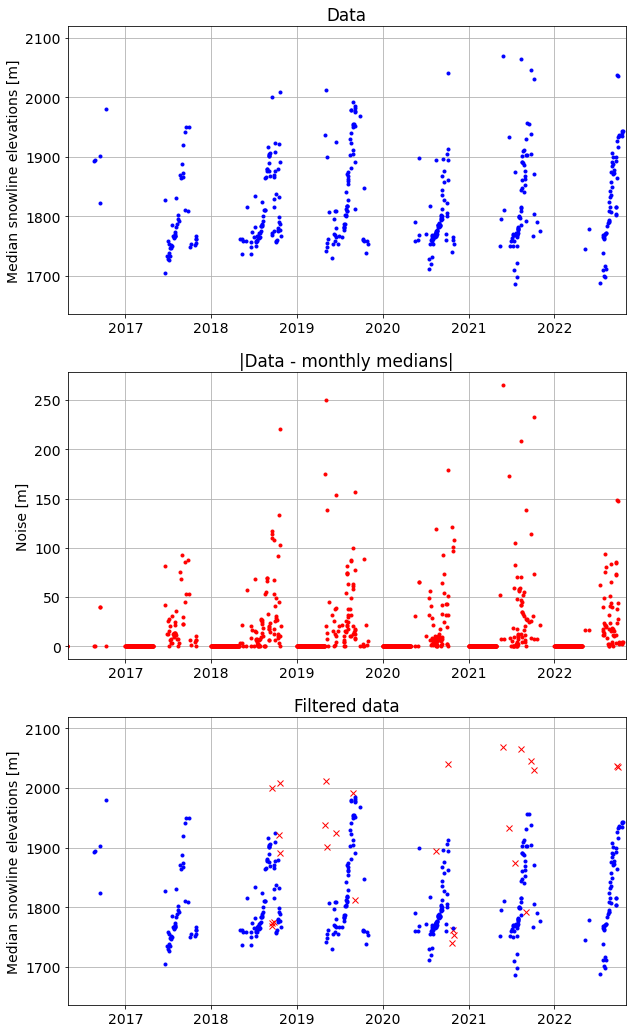

Wolverine
----------


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty s

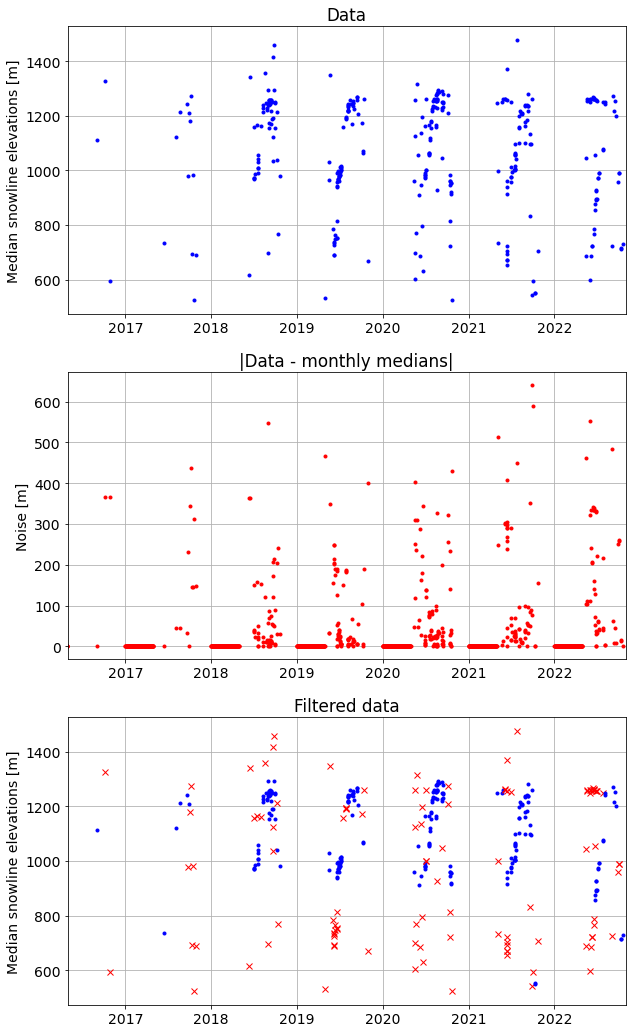

Gulkana
----------


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanm

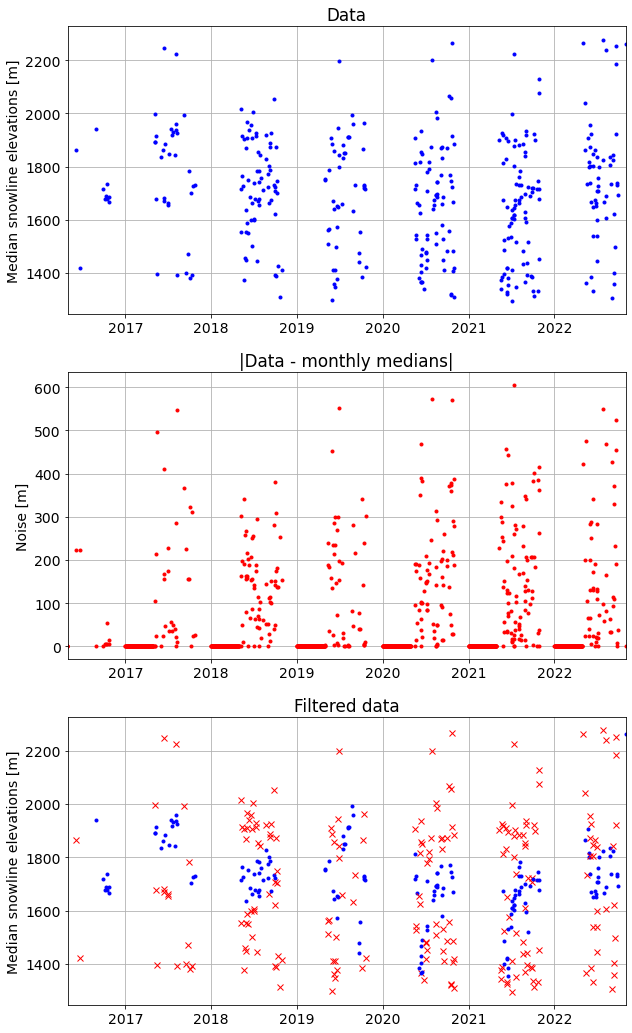

LemonCreek
----------


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = f

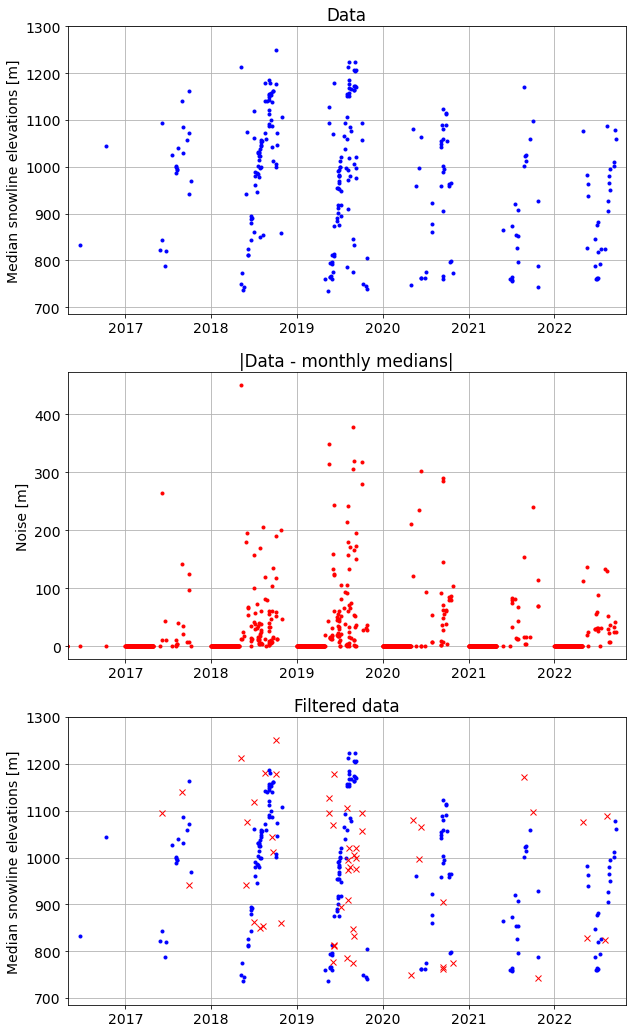

SouthCascade
----------


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanm

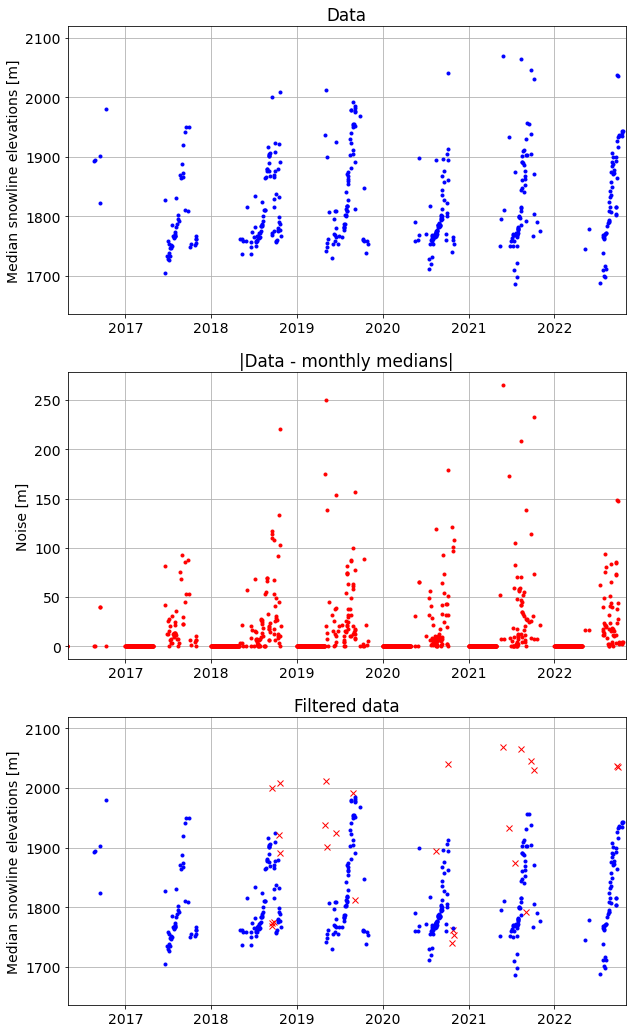

Sperry
----------


/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/raineyaberle/opt/anaconda3/envs/planet-snow/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1216: RuntimeWarning: Mean of empty slice
  return np.nanm

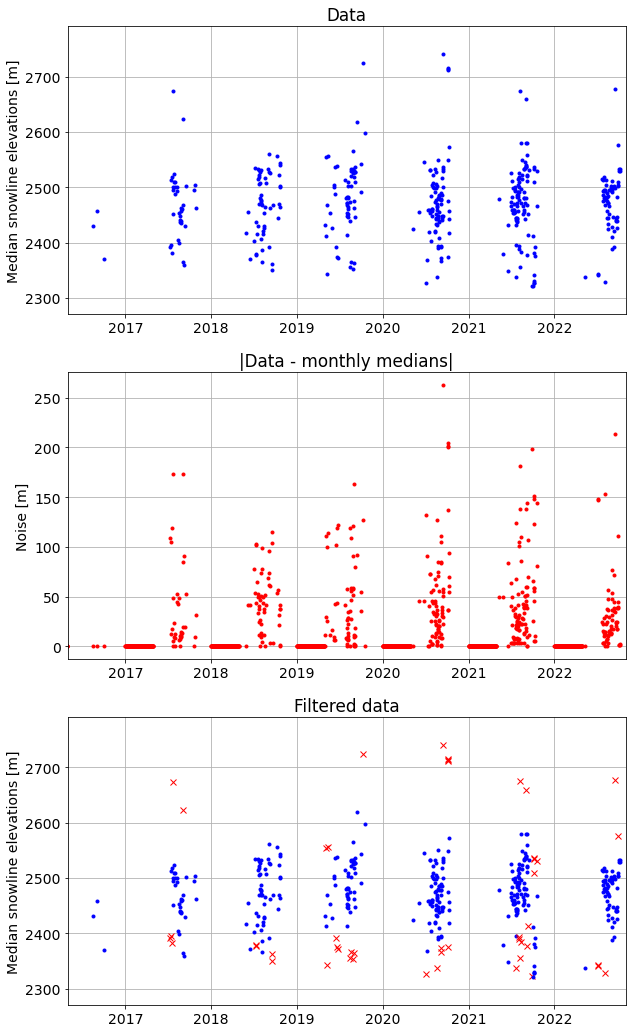

In [103]:
## Filter observations using monthly median values
site_names = ['SouthCascade','Wolverine', 'Gulkana', 'LemonCreek', 'SouthCascade', 'Sperry']

# -----loop through sites
for site_name in site_names:
    
    print(site_name)
    print('----------')
    
    # -----Load snowlines             
    # PlanetScope
    PS_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
                               '/imagery/PlanetScope/snowlines/*snowlines.pkl')[0]
    PS_sl_est = pd.read_pickle(PS_sl_est_path)
    PS_sl_est['dataset'] = 'PlanetScope'
    # Sentinel-2
    S2_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
                               '/imagery/Sentinel-2/snowlines/*snowlines.pkl')[0]
    S2_sl_est = pd.read_pickle(S2_sl_est_path)
    S2_sl_est['dataset'] = 'Sentinel2'
    # Landsat
    L_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + 
                              '/imagery/Landsat/snowlines/*snowlines.pkl')[0]
    L_sl_est = pd.read_pickle(L_sl_est_path)
    L_sl_est['dataset'] = 'Landsat'
    
    # -----Concatenate snowlines dataframes
    sl_est_full = pd.concat([PS_sl_est, S2_sl_est, L_sl_est])
    # unify datetime datatypes
    sl_est_full['datetime'] = sl_est_full['datetime'].astype(np.datetime64)
    # add year column
    sl_est_full['year'] = [x.year for x in sl_est_full['datetime']]
    # sort df by datetime
    sl_est_full = sl_est_full.sort_values(by=['datetime'])
    # grab unique years
    years = np.unique(sl_est_full['year'])
    # reformat df
    sl_est_full = sl_est_full.reset_index(drop=True)
    # set datetime as index
    sl_est_full.index = sl_est_full['datetime']
    # add day of year (doy) column
    # sl_est_full['doy'] = [x.timetuple().tm_yday for x in sl_est_full.datetime]
    # add month column
    # sl_est_full['month'] = [x.month for x in sl_est_full.datetime]
    
    # -----Set up figure
    fig, ax = plt.subplots(3, 1, figsize=(10,18))
    ax[0].plot(sl_est_full.datetime, sl_est_full.snowlines_elevs_median, '.b')
    xmin, xmax = np.datetime64('2016-05-01'), np.datetime64('2022-11-01')
    ymin, ymax = sl_est_full.snowlines_elevs_median.min()-50, sl_est_full.snowlines_elevs_median.max()+50
    ax[0].set_title('Data')
    ax[0].set_ylabel('Median snowline elevations [m]')
    ax[0].set_xlim(xmin, xmax)
    ax[0].set_ylim(ymin, ymax)
    ax[0].grid()
    ax[1].set_title('|Data - monthly medians|')
    ax[1].set_ylabel('Noise [m]')
    ax[1].set_xlim(xmin, xmax)
    ax[1].grid()
    ax[2].set_title('Filtered data')
    ax[2].set_ylabel('Median snowline elevations [m]')
    ax[2].set_xlim(xmin, xmax)
    ax[2].set_ylim(ymin, ymax)
    ax[2].grid()
    
    # -----Filter data points
    # loop through years
    sl_est_full_filt = pd.DataFrame()
    months = np.arange(0,12)
    monthly_medians = np.zeros(len(years)*len(months))
    i=0 # loop counter
    for year in years:
        # subset df to year
        df_year = sl_est_full[sl_est_full['datetime'].dt.year == year]
        # add dummy values for Jan - April
        df_year_dummy = pd.DataFrame()
        df_year_dummy['datetime'] = np.arange(np.datetime64(str(year)+'-01-01'), 
                                              np.datetime64(str(year)+'-05-01'), dtype='datetime64[D]')
        df_year_dummy['snowlines_elevs_median'] = sl_est_full['snowlines_elevs_median'].min()
        df_year = pd.concat([df_year, df_year_dummy]).sort_values(by=['datetime']).reset_index(drop=True)
        # loop through months
        for month in months:
            # subset df to month
            df_month = df_year[df_year['datetime'].dt.month==month]
            # calculate monthly median of median snowline elevations
            monthly_medians[i] = np.nanmedian(df_month['snowlines_elevs_median'])
            # print(monthly_median[i])
            # calculate noise, i.e. the difference between each point and mov_mean
            noise = np.abs(df_month.snowlines_elevs_median - monthly_medians[i])
            ax[1].plot(df_month['datetime'], noise, '.r') # plot noise
            # filter data points
            noise_thresh = 100
            ax[2].plot(df_month.iloc[noise.values >= noise_thresh]['datetime'],
                       df_month.iloc[noise.values >= noise_thresh]['snowlines_elevs_median'], 'xr')
            df_month.iloc[noise.values >= noise_thresh] = np.nan
            df_month = df_month.dropna()
            # plot filtered data
            ax[2].plot(df_month['datetime'], df_month['snowlines_elevs_median'], '.b')
            # concatenate to filtered df
            sl_est_full_filt = pd.concat([sl_est_full_filt, df_month])
            i+=1
        
    plt.show()
